<a href="https://colab.research.google.com/github/Alexjmsherman/nlp_practicum_cohort3_instructor/blob/master/lessons/lesson_6_deep_learning_for_nlp/Deep%20Learning%20for%20NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning for NLP

##### Author: Alex Sherman | alsherman@deloitte.com


Agenda:


In [0]:
from configparser import ConfigParser, ExtendedInterpolation
import os
import numpy as np
import pandas as pd
from numpy import array
from numpy import asarray
from numpy import zeros
from IPython.core.display import display, HTML
from IPython.display import Image
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from gensim.utils import simple_preprocess
from gensim.models import KeyedVectors

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, \
    Embedding, Input, GlobalAveragePooling1D, GlobalMaxPooling1D, SpatialDropout1D, GlobalMaxPool1D
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.initializers import Constant
from keras.utils import to_categorical

Using TensorFlow backend.


# Problem Definition

Predict the National Institutes of Health (NIH) Institute of Center (IC) from the Project Title of previously funded projects

In [15]:
# download NIH Project Data
!wget https://exporter.nih.gov/CSVs/final/RePORTER_PRJ_C_FY2017.zip

--2019-06-14 16:58:35--  https://exporter.nih.gov/CSVs/final/RePORTER_PRJ_C_FY2017.zip
Resolving exporter.nih.gov (exporter.nih.gov)... 165.112.228.197, 2607:f220:404:1101:165:112:228:197
Connecting to exporter.nih.gov (exporter.nih.gov)|165.112.228.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58433518 (56M) [application/x-zip-compressed]
Saving to: ‘RePORTER_PRJ_C_FY2017.zip’

RePORTER_PRJ_C_FY20 100%[===================>]  55.73M  2.05MB/s    in 27s     

2019-06-14 16:59:02 (2.04 MB/s) - ‘RePORTER_PRJ_C_FY2017.zip’ saved [58433518/58433518]



In [0]:
# zip with NIH projects
REPORTER_DATA_PATH = r'RePORTER_PRJ_C_FY2017.zip'

In [17]:
# view the data
df = pd.read_csv(
    REPORTER_DATA_PATH,
    encoding='latin-1'  # common encoding to handle messy data
)
df.head()

,APPLICATION_ID,ACTIVITY,ADMINISTERING_IC,APPLICATION_TYPE,ARRA_FUNDED,AWARD_NOTICE_DATE,BUDGET_START,BUDGET_END,CFDA_CODE,CORE_PROJECT_NUM,ED_INST_TYPE,FOA_NUMBER,FULL_PROJECT_NUM,FUNDING_ICs,FUNDING_MECHANISM,FY,IC_NAME,NIH_SPENDING_CATS,ORG_CITY,ORG_COUNTRY,ORG_DEPT,ORG_DISTRICT,ORG_DUNS,ORG_FIPS,ORG_IPF_CODE,ORG_NAME,ORG_STATE,ORG_ZIPCODE,PHR,PI_IDS,PI_NAMEs,PROGRAM_OFFICER_NAME,PROJECT_START,PROJECT_END,PROJECT_TERMS,PROJECT_TITLE,SERIAL_NUMBER,STUDY_SECTION,STUDY_SECTION_NAME,SUBPROJECT_ID,SUFFIX,SUPPORT_YEAR,DIRECT_COST_AMT,INDIRECT_COST_AMT,TOTAL_COST,TOTAL_COST_SUB_PROJECT
0,9260950,R01,MH,5.0,N,02/28/2017,03/01/2017,02/28/2018,242.0,R01MH100027,SCHOOLS OF MEDICINE,RFA-HD-12-196,5R01MH100027-10,NIMH:2759584\,Non-SBIR/STTR RPGs,2017,NATIONAL INSTITUTE OF MENTAL HEALTH,Autism; Basic Behavioral and Social Science; B...,LOS ANGELES,UNITED STATES,NONE,33.0,092530369,US,577505.0,UNIVERSITY OF CALIFORNIA LOS ANGELES,CA,900952000,PUBLIC HEALTH RELEVANCE: Project Narrative Thi...,1902475; 1882597 (contact); 6872358; 7261351; ...,"CONSTANTINO, JOHN N.; GESCHWIND, DANIEL H (con...","ADDINGTON, ANJENE M",03/25/2013,02/28/2018,admixture mapping; Affect; African; African Am...,"Autism Genetics, Phase II: Increasing Represen...",100027,ZHD1,Special Emphasis Panel,NaN,NaN,10.0,2364258.0,395326.0,2759584.0,NaN
1,9277747,U54,CA,2.0,N,05/12/2017,05/12/2017,04/30/2018,397.0,U54CA163004,SCHOOLS OF MEDICINE,RFA-CA-16-006,2U54CA163004-06,NCI:1310083\,RESEARCH CENTERS,2017,NATIONAL CANCER INSTITUTE,NaN,NEW YORK,UNITED STATES,INTERNAL MEDICINE/MEDICINE,13.0,621889815,US,1833205.0,COLUMBIA UNIVERSITY HEALTH SCIENCES,NY,100320049,OVERALL PROJECT NARRATIVE The goal of the rene...,1868587; 1872519; 1873597 (contact);,"RUSTGI, ANIL K; WANG, KENNETH K; WANG, TIMOTHY...","YASSIN, RIHAB R",09/26/2011,04/30/2022,Ablation; Antibiotics; Barrett Esophagus; Bile...,The Role of the Microenvironment in Barrett's ...,163004,ZCA1,Special Emphasis Panel,NaN,NaN,6.0,978861.0,331222.0,1310083.0,NaN
2,9466899,SB1,ES,2.0,N,09/12/2017,09/15/2017,08/31/2018,113.0,SB1ES022880,NaN,PAR-16-026,2SB1ES022880-04,NIEHS:199968\,SBIR-STTR RPGs,2017,NATIONAL INSTITUTE OF ENVIRONMENTAL HEALTH SCI...,Climate-Related Exposures and Conditions; Heal...,ROCKLEDGE,UNITED STATES,NaN,8.0,175302579,US,10005346.0,MAINSTREAM ENGINEERING CORPORATION,FL,329555327,Relevance of the Proposed Project to Public He...,11357207;,"YELVINGTON, PAUL ;","SHAUGHNESSY, DANIEL",07/11/2013,08/31/2018,Acute respiratory infection; Adhesions; Adopti...,Low-Cost Catalytic Biomass Cookstove for Impro...,022880,ZRG1,Special Emphasis Panel,NaN,NaN,4.0,94518.0,93953.0,199968.0,NaN
3,9255779,R43,GM,1.0,N,03/14/2017,04/01/2017,03/31/2019,859.0,R43GM122226,NaN,PA-15-269,1R43GM122226-01,NIGMS:223866\,SBIR-STTR RPGs,2017,NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES,Antimicrobial Resistance; Bioengineering; Infe...,BRIGHTON,UNITED STATES,NaN,7.0,079722830,US,10038518.0,"GEL4MED, INC.",MA,021351243,Surgical Site Infections are the second most c...,12645919;,"MEHTA, MANAV ;","COLE, ALISON E",04/01/2017,03/31/2019,Abdomen; Accounting; Adherence; Amino Acids; A...,Surgical Wound Closure Matrices for the Preven...,122226,ZRG1,Special Emphasis Panel,NaN,NaN,1.0,NaN,NaN,223866.0,NaN
4,9556855,ZIC,CA,1.0,N,NaN,NaN,NaN,NaN,ZICBC011574,NaN,NaN,1ZICBC011574-04,NCI:466646\,INTRAMURAL RESEARCH,2017,NATIONAL CANCER INSTITUTE,Bioengineering; Biotechnology; Cancer;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BASIC SCIENCES,NaN,NaN,NaN,8777551;,"HAGER, GORDON L;",NaN,NaN,NaN,base; Binding; CCR; Cells; Cellular Structures...,LRBGE Optical Microscopy Core,011574,NaN,NaN,NaN,NaN,4.0,NaN,NaN,466646.0,NaN


In [18]:
# filter to relevant columns
df = df[['ADMINISTERING_IC', 'FY',  'IC_NAME', 'PROJECT_TITLE']]
df.head()

,ADMINISTERING_IC,FY,IC_NAME,PROJECT_TITLE
0,MH,2017,NATIONAL INSTITUTE OF MENTAL HEALTH,"Autism Genetics, Phase II: Increasing Represen..."
1,CA,2017,NATIONAL CANCER INSTITUTE,The Role of the Microenvironment in Barrett's ...
2,ES,2017,NATIONAL INSTITUTE OF ENVIRONMENTAL HEALTH SCI...,Low-Cost Catalytic Biomass Cookstove for Impro...
3,GM,2017,NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES,Surgical Wound Closure Matrices for the Preven...
4,CA,2017,NATIONAL CANCER INSTITUTE,LRBGE Optical Microscopy Core


In [19]:
# observe IC representation in dataset
df['IC_NAME'].value_counts()

NATIONAL CANCER INSTITUTE                                                          11406
NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASES                               7744
NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES                                      7587
NATIONAL HEART, LUNG, AND BLOOD INSTITUTE                                           6456
NATIONAL INSTITUTE OF DIABETES AND DIGESTIVE AND KIDNEY DISEASES                    5051
NATIONAL INSTITUTE OF NEUROLOGICAL DISORDERS AND STROKE                             4591
NATIONAL INSTITUTE ON AGING                                                         3928
NATIONAL INSTITUTE OF MENTAL HEALTH                                                 3515
EUNICE KENNEDY SHRIVER NATIONAL INSTITUTE OF CHILD HEALTH & HUMAN DEVELOPMENT       3375
NATIONAL INSTITUTE ON DRUG ABUSE                                                    2569
NATIONAL EYE INSTITUTE                                                              1809
NATIONAL INSTITUTE OF

In [20]:
# convert IC counts to a dataframe
top_ic = df['IC_NAME'].value_counts().reset_index()

# filter to top ICs
top_ic_names = top_ic[top_ic.IC_NAME > 1500]['index']

# view results
top_ic_names

0                             NATIONAL CANCER INSTITUTE
1     NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS D...
2        NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES
3             NATIONAL HEART, LUNG, AND BLOOD INSTITUTE
4     NATIONAL INSTITUTE OF DIABETES AND DIGESTIVE A...
5     NATIONAL INSTITUTE OF NEUROLOGICAL DISORDERS A...
6                           NATIONAL INSTITUTE ON AGING
7                   NATIONAL INSTITUTE OF MENTAL HEALTH
8     EUNICE KENNEDY SHRIVER NATIONAL INSTITUTE OF C...
9                      NATIONAL INSTITUTE ON DRUG ABUSE
10                               NATIONAL EYE INSTITUTE
11    NATIONAL INSTITUTE OF ENVIRONMENTAL HEALTH SCI...
12    NATIONAL INSTITUTE OF ARTHRITIS AND MUSCULOSKE...
Name: index, dtype: object

In [21]:
# view new data subset
df = df[df['IC_NAME'].isin(top_ic_names)]
df.shape

(61363, 4)

In [22]:
# factorize - convert category names to numbers
df['IC_NAME'].factorize()

(array([ 0,  1,  2, ...,  1, 11,  1]),
 Index(['NATIONAL INSTITUTE OF MENTAL HEALTH', 'NATIONAL CANCER INSTITUTE',
        'NATIONAL INSTITUTE OF ENVIRONMENTAL HEALTH SCIENCES',
        'NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES',
        'NATIONAL INSTITUTE OF NEUROLOGICAL DISORDERS AND STROKE',
        'NATIONAL INSTITUTE ON AGING',
        'NATIONAL HEART, LUNG, AND BLOOD INSTITUTE',
        'NATIONAL INSTITUTE OF DIABETES AND DIGESTIVE AND KIDNEY DISEASES',
        'EUNICE KENNEDY SHRIVER NATIONAL INSTITUTE OF CHILD HEALTH & HUMAN DEVELOPMENT',
        'NATIONAL EYE INSTITUTE', 'NATIONAL INSTITUTE ON DRUG ABUSE',
        'NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASES',
        'NATIONAL INSTITUTE OF ARTHRITIS AND MUSCULOSKELETAL AND SKIN DISEASES'],
       dtype='object'))

In [23]:
# set the labels as a new column
df['IC_NUM'] = df['ADMINISTERING_IC'].factorize()[0]
df.head()

,ADMINISTERING_IC,FY,IC_NAME,PROJECT_TITLE,IC_NUM
0,MH,2017,NATIONAL INSTITUTE OF MENTAL HEALTH,"Autism Genetics, Phase II: Increasing Represen...",0
1,CA,2017,NATIONAL CANCER INSTITUTE,The Role of the Microenvironment in Barrett's ...,1
2,ES,2017,NATIONAL INSTITUTE OF ENVIRONMENTAL HEALTH SCI...,Low-Cost Catalytic Biomass Cookstove for Impro...,2
3,GM,2017,NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES,Surgical Wound Closure Matrices for the Preven...,3
4,CA,2017,NATIONAL CANCER INSTITUTE,LRBGE Optical Microscopy Core,1


In [24]:
# create a map of IC nums to names for later reference
ic_name_map = {num:name for num, name in df[['IC_NUM','IC_NAME']].drop_duplicates().values}
ic_name_map

{0: 'NATIONAL INSTITUTE OF MENTAL HEALTH',
 1: 'NATIONAL CANCER INSTITUTE',
 2: 'NATIONAL INSTITUTE OF ENVIRONMENTAL HEALTH SCIENCES',
 3: 'NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES',
 4: 'NATIONAL INSTITUTE OF NEUROLOGICAL DISORDERS AND STROKE',
 5: 'NATIONAL INSTITUTE ON AGING',
 6: 'NATIONAL HEART, LUNG, AND BLOOD INSTITUTE',
 7: 'NATIONAL INSTITUTE OF DIABETES AND DIGESTIVE AND KIDNEY DISEASES',
 8: 'EUNICE KENNEDY SHRIVER NATIONAL INSTITUTE OF CHILD HEALTH & HUMAN DEVELOPMENT',
 9: 'NATIONAL EYE INSTITUTE',
 10: 'NATIONAL INSTITUTE ON DRUG ABUSE',
 11: 'NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASES',
 12: 'NATIONAL INSTITUTE OF ARTHRITIS AND MUSCULOSKELETAL AND SKIN DISEASES'}

# Preprocess data and create Train/Test splits

In [0]:
# separate the features and response
X = df['PROJECT_TITLE']
y = df['IC_NUM']

In [26]:
# use gensim to preprocess text 

for title in X[0:5]:
    clean_title_tokens = simple_preprocess(title)
    clean_title = ' '.join(clean_title_tokens)
    
    print(title)
    print(clean_title_tokens)
    print(clean_title)
    print()

Autism Genetics, Phase II: Increasing Representation of Human Diversity
['autism', 'genetics', 'phase', 'ii', 'increasing', 'representation', 'of', 'human', 'diversity']
autism genetics phase ii increasing representation of human diversity

The Role of the Microenvironment in Barrett's Esophagus
['the', 'role', 'of', 'the', 'in', 'barrett', 'esophagus']
the role of the in barrett esophagus

Low-Cost Catalytic Biomass Cookstove for Improved Indoor Air Quality
['low', 'cost', 'catalytic', 'biomass', 'cookstove', 'for', 'improved', 'indoor', 'air', 'quality']
low cost catalytic biomass cookstove for improved indoor air quality

Surgical Wound Closure Matrices for the Prevention of Superficial Incisional SSI
['surgical', 'wound', 'closure', 'matrices', 'for', 'the', 'prevention', 'of', 'superficial', 'incisional', 'ssi']
surgical wound closure matrices for the prevention of superficial incisional ssi

LRBGE Optical Microscopy Core
['lrbge', 'optical', 'microscopy', 'core']
lrbge optical mi

In [0]:
# use gensim to preprocess text 

def preprocess_text(text):
    """ use gensim simple_preprocess to tokenize text. Join results back into a clean text string
    
    :param text: string, text to preprocess
    """
    
    clean_tokens = simple_preprocess(text)
    clean_text = ' '.join(clean_tokens)
    
    return clean_text


X = X.apply(lambda x: preprocess_text(x))

In [28]:
# Create train test splits

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=42)
y_train.value_counts(normalize=True)

1     0.185889
11    0.126201
3     0.123637
6     0.105211
7     0.082308
4     0.074812
5     0.064013
0     0.057277
8     0.054995
10    0.041871
9     0.029486
2     0.028617
12    0.025683
Name: IC_NUM, dtype: float64

### Explore Data

In [29]:
# view the distribution of words in a project title
X_train.apply(len).describe()

count    46022.000000
mean        60.746860
std         25.154798
min          0.000000
25%         44.000000
50%         60.000000
75%         76.000000
max        199.000000
Name: PROJECT_TITLE, dtype: float64

# Keras

In [30]:
sqlalchemy_url = 'https://keras.io/'
iframe = '<iframe src={} width=1100 height=600></iframe>'.format(sqlalchemy_url)
HTML(iframe)

# Document Classification with Deep Learning Approach

### 1. convert all text samples in the dataset into sequences of word indices. 
- A "word index" would simply be an integer ID for the word. 
- We will only consider the top N most commonly occuring words in the dataset, and we will truncate the sequences to a defined maximum length of words.

### 2. prepare an "embedding matrix" which will contain at index i the embedding vector for the word of index i in our word index.


### 3. load this embedding matrix into a Keras Embedding layer, set to be frozen 
- its weights, the embedding vectors, will not be updated during training.


### 4. build a deep learning model (e.g. CNN, RNN), ending in a softmax output.



SOURCE: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

# 1. convert all text samples in the dataset into sequences of word indices. 

In [31]:
# get a count of the number of possible categories to predict
num_classes = len(set(y_train))
num_classes

13

In [32]:
# convert the training and testing dataset
y_train_array = to_categorical(y_train, num_classes)
y_test_array = to_categorical(y_test, num_classes)

# each label is one-hot encoded into a vector of size num_classes
y_train_array

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

## Keras Tokenizer

In [0]:
# prepare tokenizer
MAX_NUM_WORDS = 25000

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

In [34]:
print(dir(tokenizer))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_keras_api_names', '_keras_api_names_v1', 'char_level', 'document_count', 'filters', 'fit_on_sequences', 'fit_on_texts', 'get_config', 'index_docs', 'index_word', 'lower', 'num_words', 'oov_token', 'sequences_to_matrix', 'sequences_to_texts', 'sequences_to_texts_generator', 'split', 'texts_to_matrix', 'texts_to_sequences', 'texts_to_sequences_generator', 'to_json', 'word_counts', 'word_docs', 'word_index']


In [0]:
# learn the vocabulary from the training documents
tokenizer.fit_on_texts(X_train)

##### Example what the tokenizer has learned from the text

In [36]:
tokenizer.document_count

46022

In [37]:
# increment the vocab count by one as the first embedding must be blank for later activities in Keras
vocab_size = len(tokenizer.word_index) + 1
vocab_size

20439

In [38]:
# get word counts that the tokenizer learned
list(tokenizer.word_counts.items())[0:10]

[('determining', 79),
 ('the', 8779),
 ('role', 2315),
 ('of', 22665),
 ('dnmt', 9),
 ('interacting', 21),
 ('rnas', 83),
 ('in', 15958),
 ('myeloid', 91),
 ('disorders', 353)]

In [39]:
# view the most common words
sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[0:10]

[('of', 22665),
 ('and', 17661),
 ('in', 15958),
 ('the', 8779),
 ('for', 7141),
 ('to', 4392),
 ('core', 3996),
 ('cancer', 3021),
 ('cell', 2685),
 ('research', 2425)]

In [40]:
# get counts of in how many documents each token exists
list(tokenizer.word_docs.items())[0:10]

[('in', 15331),
 ('interacting', 21),
 ('dnmt', 9),
 ('the', 7864),
 ('disorders', 353),
 ('role', 2315),
 ('myeloid', 91),
 ('determining', 79),
 ('of', 20429),
 ('rnas', 83)]

In [41]:
# get a word to index mapping
list(tokenizer.word_index.items())[0:10]

[('of', 1),
 ('and', 2),
 ('in', 3),
 ('the', 4),
 ('for', 5),
 ('to', 6),
 ('core', 7),
 ('cancer', 8),
 ('cell', 9),
 ('research', 10)]

In [42]:
# get a index to word mapping
list(tokenizer.index_word.items())[0:10]

[(1, 'of'),
 (2, 'and'),
 (3, 'in'),
 (4, 'the'),
 (5, 'for'),
 (6, 'to'),
 (7, 'core'),
 (8, 'cancer'),
 (9, 'cell'),
 (10, 'research')]

## convert the sentences to a sequence of token ids

In [43]:
encoded_docs = tokenizer.texts_to_sequences(X_train)
print(X_train[0:5], '\n')
encoded_docs[0:5]

10516    determining the role of dnmt interacting rnas ...
65466                                      morphology core
57760    cognitive and neural moderators of longitudina...
50413    exploiting mutant idh induced homologous recom...
53219    analysis of intracellular host defenses in sal...
Name: PROJECT_TITLE, dtype: object 



[[688, 4, 12, 1, 3690, 2063, 660, 3, 599, 134],
 [1367, 7],
 [98, 2, 67, 3691, 1, 311, 761, 3, 1935, 611],
 [1231, 554, 1989, 48, 2409, 820, 717, 3, 8],
 [34, 1, 798, 122, 2919, 3, 1173, 97]]

## pad the sequences to make the matrix size consistent

In [44]:
# pad documents to a max length of 10 words

MAX_SEQ_LENGTH = 10
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQ_LENGTH, padding='post')
print(padded_docs[0:5])

[[ 688    4   12    1 3690 2063  660    3  599  134]
 [1367    7    0    0    0    0    0    0    0    0]
 [  98    2   67 3691    1  311  761    3 1935  611]
 [1231  554 1989   48 2409  820  717    3    8    0]
 [  34    1  798  122 2919    3 1173   97    0    0]]


In [0]:
# encode both train and test data (only learn from the training data)

def encode_text(text):
    """ convert an array of text into a series of padded token interger-ids 
    
    :param text: series, text to tokenize and pad with 0's
    """
    
    encoded_docs = tokenizer.texts_to_sequences(text)
    padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQ_LENGTH, padding='post')    
    
    return padded_docs


X_train_sequence = encode_text(X_train)
X_test_sequence = encode_text(X_test)

In [0]:
  ###################### INCORPORATE THIS ABOVE 
  def encode_text(self, text, train=False):
        if train:
            self.tokenizer = Tokenizer(num_words=self.max_num_words)
            self.tokenizer.fit_on_texts(text)

        encoded_docs = self.tokenizer.texts_to_sequences(text)
        padded_docs = pad_sequences(
            encoded_docs,
            maxlen=self.max_seq_length,
            padding='post'
        )

        print(f'completed tokenizing and padding text - train: {train}')
        self.vocab_size = len(self.tokenizer.word_index) + 1
        return padded_docs

# 2. prepare an "embedding matrix" which will contain at index i the embedding vector for the word of index i in our word index.

### Download pre-trained embeddings

##### GLOVE
- GLoVE - Global Vectors for Word Representation: https://nlp.stanford.edu/projects/glove/
- Publication: https://nlp.stanford.edu/pubs/glove.pdf

In [47]:
# download pretrained embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

# uncomment below for 2GB GLoVe Embeddings
#!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2019-06-14 16:59:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-06-14 16:59:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-06-14 16:59:13--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [48]:
%ls

gdrive/       RePORTER_PRJ_C_FY2017.zip  wikipedia-pubmed-and-PMC-w2v.bin
glove.6B.zip  sample_data/


In [49]:
%%time

from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "glove.6B.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as z:
  
    # print all the contents of the zip file 
    z.printdir() 
  
    # extracting all the files 
    z.extractall() 

File Name                                             Modified             Size
glove.6B.50d.txt                               2014-08-04 13:15:00    171350079
glove.6B.100d.txt                              2014-08-04 13:14:34    347116733
glove.6B.200d.txt                              2014-08-04 13:14:44    693432828
glove.6B.300d.txt                              2014-08-27 12:19:16   1037962819
CPU times: user 14.7 s, sys: 2.44 s, total: 17.1 s
Wall time: 17.7 s


In [50]:
%ls

gdrive/            glove.6B.300d.txt  RePORTER_PRJ_C_FY2017.zip
glove.6B.100d.txt  glove.6B.50d.txt   sample_data/
glove.6B.200d.txt  glove.6B.zip       wikipedia-pubmed-and-PMC-w2v.bin


In [0]:
# Glove Word Embeddings
GLOVE_DIR = 'glove.6B.300d.txt'
EMBEDDING_SIZE = 300

In [52]:
with open(GLOVE_DIR) as f:
    for line in f:
        print(line, '\n')
        break

the 0.04656 0.21318 -0.0074364 -0.45854 -0.035639 0.23643 -0.28836 0.21521 -0.13486 -1.6413 -0.26091 0.032434 0.056621 -0.043296 -0.021672 0.22476 -0.075129 -0.067018 -0.14247 0.038825 -0.18951 0.29977 0.39305 0.17887 -0.17343 -0.21178 0.23617 -0.063681 -0.42318 -0.11661 0.093754 0.17296 -0.33073 0.49112 -0.68995 -0.092462 0.24742 -0.17991 0.097908 0.083118 0.15299 -0.27276 -0.038934 0.54453 0.53737 0.29105 -0.0073514 0.04788 -0.4076 -0.026759 0.17919 0.010977 -0.10963 -0.26395 0.07399 0.26236 -0.1508 0.34623 0.25758 0.11971 -0.037135 -0.071593 0.43898 -0.040764 0.016425 -0.4464 0.17197 0.046246 0.058639 0.041499 0.53948 0.52495 0.11361 -0.048315 -0.36385 0.18704 0.092761 -0.11129 -0.42085 0.13992 -0.39338 -0.067945 0.12188 0.16707 0.075169 -0.015529 -0.19499 0.19638 0.053194 0.2517 -0.34845 -0.10638 -0.34692 -0.19024 -0.2004 0.12154 -0.29208 0.023353 -0.11618 -0.35768 0.062304 0.35884 0.02906 0.0073005 0.0049482 -0.15048 -0.12313 0.19337 0.12173 0.44503 0.25147 0.10781 -0.17716 0.0386

In [53]:
# iterate and extract the embeddings

with open(GLOVE_DIR, 'rb') as f:

    for line in f:
        # separate the word from the embedding
        values = line.split()
        word = values[0].decode('utf-8')  # decode bytes to unicode
        embedding = np.asarray(values[1:], dtype='float32')

        # print the results
        print(f'WORD: {word}\n')
        print(f'EMBEDDING: {embedding}')

        break

WORD: the

EMBEDDING: [ 4.6560e-02  2.1318e-01 -7.4364e-03 -4.5854e-01 -3.5639e-02  2.3643e-01
 -2.8836e-01  2.1521e-01 -1.3486e-01 -1.6413e+00 -2.6091e-01  3.2434e-02
  5.6621e-02 -4.3296e-02 -2.1672e-02  2.2476e-01 -7.5129e-02 -6.7018e-02
 -1.4247e-01  3.8825e-02 -1.8951e-01  2.9977e-01  3.9305e-01  1.7887e-01
 -1.7343e-01 -2.1178e-01  2.3617e-01 -6.3681e-02 -4.2318e-01 -1.1661e-01
  9.3754e-02  1.7296e-01 -3.3073e-01  4.9112e-01 -6.8995e-01 -9.2462e-02
  2.4742e-01 -1.7991e-01  9.7908e-02  8.3118e-02  1.5299e-01 -2.7276e-01
 -3.8934e-02  5.4453e-01  5.3737e-01  2.9105e-01 -7.3514e-03  4.7880e-02
 -4.0760e-01 -2.6759e-02  1.7919e-01  1.0977e-02 -1.0963e-01 -2.6395e-01
  7.3990e-02  2.6236e-01 -1.5080e-01  3.4623e-01  2.5758e-01  1.1971e-01
 -3.7135e-02 -7.1593e-02  4.3898e-01 -4.0764e-02  1.6425e-02 -4.4640e-01
  1.7197e-01  4.6246e-02  5.8639e-02  4.1499e-02  5.3948e-01  5.2495e-01
  1.1361e-01 -4.8315e-02 -3.6385e-01  1.8704e-01  9.2761e-02 -1.1129e-01
 -4.2085e-01  1.3992e-01 -3.9

In [54]:
# Store all embeddings {'token': n-dimensional embedding_series}

embeddings_index = {}

with open(GLOVE_DIR, 'rb') as f:
    for line in f:
        values = line.split()
        word = values[0].decode('utf-8')
        embedding = np.asarray(values[1:], dtype='float32')

        # store the embeddings in a dict
        embeddings_index[word] = embedding
        
        print(embeddings_index)
        break

{'the': array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-0

In [55]:
%%time

# Store all embeddings {'token': n-dimensional embedding_series}
embeddings_index = {}

with open(GLOVE_DIR, 'rb') as f:
    for line in f:
        values = line.split()
        word = values[0].decode('utf-8')
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.
CPU times: user 18.9 s, sys: 545 ms, total: 19.4 s
Wall time: 19.4 s


##### View the stored embeddings

In [56]:
embeddings_index['the']

array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

##### Test out other words to see if a pre-trained embedding exists

In [57]:
word = "word" # test out new words in the quotes (capitalization sensitive)

embeddings_index[word]

array([-4.3036e-01, -4.0622e-01, -1.8279e-01, -1.2548e-01,  4.3490e-02,
       -2.1216e-01, -3.6509e-01,  3.2598e-02, -1.0828e-01, -1.3537e+00,
       -1.9152e-01,  1.8976e-01, -4.3755e-01,  2.4337e-01,  2.9676e-01,
       -4.2886e-02, -4.9444e-02,  3.7994e-01,  5.5679e-02,  1.0740e-01,
       -1.5195e-01,  2.7901e-03, -5.0005e-02,  1.6948e-01, -1.7819e-01,
       -1.7449e-01,  1.8066e-01, -3.5179e-01,  4.3839e-01,  2.3936e-01,
       -1.2200e-01, -1.3631e-02, -2.7989e-01,  4.4950e-01, -6.5760e-01,
       -7.7317e-02,  6.9246e-02, -7.7499e-01, -4.3509e-01,  1.6177e-01,
       -9.4878e-02,  2.5968e-01, -3.6336e-02,  2.0131e-01,  1.6860e-01,
       -4.3616e-01, -2.1700e-02,  6.6751e-02, -3.5336e-01,  3.5581e-01,
        4.3044e-01, -1.2607e-01,  9.4664e-01,  2.5349e-01, -6.7874e-01,
        1.0727e-01,  1.1090e-01, -2.2619e-02,  5.4648e-01,  6.4194e-01,
        7.1169e-01,  4.4902e-02,  1.0753e-01,  4.5971e-01, -4.1282e-02,
        2.1160e-01,  3.2395e-01,  1.9663e-01,  4.1871e-01,  3.72

##### Determine if the words learned from the tokenizer have existing embeddings

In [58]:
list(tokenizer.index_word.items())[0:10]

[(1, 'of'),
 (2, 'and'),
 (3, 'in'),
 (4, 'the'),
 (5, 'for'),
 (6, 'to'),
 (7, 'core'),
 (8, 'cancer'),
 (9, 'cell'),
 (10, 'research')]

In [59]:
# iterate through all the words in the sentence
for ind, word in list(tokenizer.index_word.items())[0:10]:

    # get the embedding for the word
    embedding_vector = embeddings_index.get(word, 'no embedding')

    # view the word and embedding
    print(word)
    print(embedding_vector, '\n')

of
[-7.6947e-02 -2.1211e-02  2.1271e-01 -7.2232e-01 -1.3988e-01 -1.2234e-01
 -1.7521e-01  1.2137e-01 -7.0866e-02 -1.5721e+00 -2.2464e-01  4.2690e-02
 -4.0180e-01  2.1006e-01  1.4288e-02  4.1628e-01  1.7165e-02  7.1732e-02
  6.9246e-03  1.8107e-01 -1.5412e-01  1.4933e-01 -3.0493e-02  2.9918e-01
  2.9479e-02 -3.6147e-02 -6.1125e-02  8.3918e-02 -1.2398e-01 -1.0077e-01
 -5.4142e-03  3.3710e-01 -2.5612e-01  4.4388e-01 -6.8922e-01  1.8020e-01
  3.4898e-01 -5.2284e-02 -2.6226e-01 -4.7109e-01  2.1647e-01 -4.0020e-01
 -4.9986e-02  1.1376e-02  5.4994e-01 -2.2791e-01  9.5873e-02  4.7693e-01
 -5.6727e-02 -1.7895e-01  1.1756e-01  1.4662e-01  4.8948e-02  1.3587e-01
 -9.3821e-02  4.5968e-01 -3.2062e-01  2.9911e-01  2.0656e-01 -1.8503e-01
 -2.7690e-01 -2.2545e-02  7.0698e-01 -2.3815e-01  1.6437e-01 -5.5044e-01
 -1.0615e-03  1.2266e-01  1.1898e-01  2.3985e-01  2.9815e-01  1.3207e-02
  1.6316e-01 -6.1334e-01 -3.7051e-01  1.9444e-01 -1.3621e-01 -3.0426e-01
 -3.7715e-01  6.5299e-02 -1.5995e-01 -5.6516e-01

In [60]:
embeddings_count = 0
oov = []

for ind, word in list(tokenizer.index_word.items()):
    # get the embedding for the word
    embedding_exists = embeddings_index.get(word, False)
    
    # count the embeddings that were pre-trained; keep track of out of vocabulary (oov) words
    if embedding_exists is not False:
        embeddings_count += 1
    else:
        oov.append(word)

# calculate the percentage of words that existed in the pre-trained embeddings
print(f'{embeddings_count / len(tokenizer.index_word): 2.2f}% words existed in pre-trained embeddings \n')
print(f'OUT OF VOCABULARY WORDS: \n{oov[0:20]}')

 0.72% words existed in pre-trained embeddings 

OUT OF VOCABULARY WORDS: 
['phenotyping', 'predoctoral', 'crispr', 'cardiometabolic', 'biospecimen', 'synuclein', 'optogenetic', 'metabolomic', 'biorepository', 'crcns', 'epigenomic', 'ncorp', 'mtorc', 'inflammasome', 'transcriptomic', 'proteostasis', 'epigenomics', 'hhsn', 'abeta', 'neuroaids']


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, EMBEDDING_SIZE))

for word, i in tokenizer.word_index.items():    
    embedding_vector = embeddings_index.get(word)
    
    # add each word in the embedding_matrix in the slot for the tokenizer's word id
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [62]:
# view the embedding look up table
print(embedding_matrix[0:5])

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.076947   -0.021211    0.21270999 ...  0.18351001 -0.29183
  -0.046533  ]
 [ 0.038466   -0.039792    0.082747   ... -0.33427     0.011807
   0.059703  ]
 [-0.44398999  0.12817    -0.25246999 ... -0.20043001 -0.082191
  -0.06255   ]
 [ 0.04656     0.21318001 -0.0074364  ...  0.0090611  -0.20988999
   0.053913  ]]


##### View an example of looking up a word by the tokenizer id in the embedding matrix

In [63]:
embeddings_index['good']

array([-1.3602e-01, -1.1594e-01, -1.7078e-02, -2.9256e-01,  1.6149e-02,
        8.6472e-02,  1.5759e-03,  3.4395e-01,  2.1661e-01, -2.1366e+00,
        3.5278e-01, -2.3909e-01, -2.2174e-01,  3.6413e-01, -4.5021e-01,
        1.2104e-01, -1.5596e-01, -3.8906e-02, -2.9419e-03,  1.6009e-02,
       -1.1620e-01,  3.8680e-01,  3.5109e-01,  9.7426e-02, -1.2425e-02,
       -1.7864e-01, -2.3259e-01, -2.6960e-01,  4.1083e-02, -7.6194e-02,
       -2.3362e-01,  2.0919e-01, -2.7264e-01,  5.4967e-02, -1.8055e+00,
        5.6348e-01, -1.2778e-01,  2.3147e-01, -5.8820e-03, -2.6630e-01,
        4.1187e-01, -3.7162e-01, -2.0600e-01, -1.9619e-01, -4.3945e-03,
        1.2513e-01,  4.6638e-01,  4.5159e-01, -1.5000e-01,  5.9589e-03,
        5.9070e-02, -4.1440e-01,  6.1035e-02, -2.1117e-01, -4.0988e-01,
        5.6393e-01,  2.3021e-01,  2.7240e-01,  4.9364e-02,  1.4239e-01,
        4.1841e-01, -1.3983e-01,  3.4826e-01, -1.0745e-01, -2.5002e-01,
       -3.2554e-01,  3.3343e-01, -3.5617e-01,  2.0442e-01,  1.44

In [64]:
token_id = tokenizer.texts_to_sequences(['good'])
token_id

[[8769]]

In [65]:
print(embedding_matrix[token_id[0]])

[[-1.36020005e-01 -1.15939997e-01 -1.70779992e-02 -2.92560011e-01
   1.61489993e-02  8.64719972e-02  1.57590001e-03  3.43950003e-01
   2.16610000e-01 -2.13660002e+00  3.52780014e-01 -2.39089996e-01
  -2.21740007e-01  3.64129990e-01 -4.50210005e-01  1.21040002e-01
  -1.55959994e-01 -3.89060006e-02 -2.94189993e-03  1.60089992e-02
  -1.16200000e-01  3.86799991e-01  3.51090014e-01  9.74259973e-02
  -1.24249998e-02 -1.78639993e-01 -2.32590005e-01 -2.69600004e-01
   4.10830006e-02 -7.61940032e-02 -2.33620003e-01  2.09189996e-01
  -2.72639990e-01  5.49670011e-02 -1.80550003e+00  5.63480020e-01
  -1.27780005e-01  2.31470004e-01 -5.88200008e-03 -2.66299993e-01
   4.11870003e-01 -3.71619999e-01 -2.06000000e-01 -1.96190000e-01
  -4.39450005e-03  1.25129998e-01  4.66380000e-01  4.51590002e-01
  -1.50000006e-01  5.95889986e-03  5.90699986e-02 -4.14400011e-01
   6.10349998e-02 -2.11170003e-01 -4.09880012e-01  5.63929975e-01
   2.30210006e-01  2.72399992e-01  4.93640006e-02  1.42389998e-01
   4.18410

##### Create embeddings for an entire sentence

In [66]:
example_sentence = X_train[0]
example_sentence

'autism genetics phase ii increasing representation of human diversity'

In [67]:
sentence_ids = tokenizer.texts_to_sequences([example_sentence])
sentence_ids

[[316, 167, 220, 367, 1384, 2885, 1, 30, 390]]

In [68]:
# structure the embeddings of each word in a sentence
sentence_embedding = pd.DataFrame(
    [embedding_matrix[word_id] for word_id in sentence_ids][0],  # store the embedding of each word in a list
    index=example_sentence.split()  # use the words (from the original sentence) as the row index
)

sentence_embedding

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
autism,-0.577110,-0.047541,-0.346660,0.607970,-0.133210,-0.097940,-0.47797,-0.203540,0.263020,-0.26057,-0.228300,0.391980,-0.46936,-0.041414,0.285190,0.160070,-0.151940,-0.302390,-0.041395,-0.331850,-0.230280,0.234090,-0.617670,-0.594730,0.351140,0.283280,0.348130,-0.556030,-0.269270,-0.979110,0.230160,0.36616,-0.088943,0.54162,0.080725,-0.48510,-0.22343,0.158240,0.023828,-0.11906,...,-0.057573,-0.542400,-0.016148,0.238660,-0.396550,0.387950,0.304850,0.356470,0.216760,0.377740,0.338540,-0.084518,0.049732,-0.760300,0.083267,-0.580730,-0.673590,-0.204930,0.69077,0.094522,0.168610,-0.97052,-0.145160,0.624270,-0.223530,0.535260,-0.426380,0.213970,-0.62794,-0.015609,-0.260270,-0.573370,-0.528360,-0.021712,-0.000082,-0.471550,-0.034789,0.300500,0.365460,-0.945990
genetics,0.253350,-0.307480,0.398930,-0.031933,-0.108860,-0.237200,-0.74439,-0.518750,0.903140,-0.71643,0.511350,-0.422040,0.15115,0.085128,0.894900,-0.121530,0.670600,-0.138050,-0.614760,0.105960,-0.327120,-0.016876,0.114670,0.265710,0.176540,0.554200,0.744940,-0.260970,-0.559610,-0.796200,0.212070,-0.47206,-0.405860,0.29869,0.337000,0.21520,0.12606,0.496880,-1.082700,-0.54738,...,0.250900,-0.440100,0.173110,-0.282480,-0.064851,0.029397,-0.175000,0.466380,-0.019494,0.486290,0.106870,-0.200090,-0.373400,-0.635810,0.177980,-0.024251,0.033523,0.131890,0.33499,-0.482150,-0.581870,-0.45027,0.448570,0.481270,-0.167020,-0.299960,0.021929,0.130850,0.42753,-0.221610,0.073924,-0.854570,0.245100,0.047740,0.114970,0.123130,0.568150,0.327580,0.091366,0.057238
phase,0.015768,0.599800,0.022085,-0.054721,0.403730,0.037821,0.10540,-0.009565,0.117470,-1.56670,0.046372,-0.355010,-0.23051,-0.238830,0.401980,0.027941,-0.469510,-0.495720,0.134900,-0.007445,-0.182880,-0.502920,-0.009797,0.282450,0.081191,-0.198050,-0.076013,-0.330350,-0.290580,0.091952,0.181030,0.23564,-0.002848,0.29937,-0.010066,0.93563,-0.27732,0.069571,0.227640,0.55808,...,0.418440,0.235090,0.390370,-0.038814,0.350840,0.115450,-0.241420,-0.122330,0.910000,0.275900,0.684320,0.121910,-0.173400,0.135250,0.433620,0.159510,-1.585900,0.062732,0.51973,-0.235250,-0.499090,-0.40660,-0.094308,-0.113800,0.259930,0.276010,-0.103620,-0.222150,-0.76629,-0.128430,-0.537030,-0.151400,-0.164810,0.153770,0.768030,0.839280,-0.131770,-0.035794,0.212860,-0.059031
ii,-0.376750,0.383030,0.294160,-0.389710,0.389710,0.209050,-0.10193,0.090303,-0.157130,-1.75790,0.271880,0.004924,0.22892,-0.434630,-0.121710,-0.400790,0.091403,-0.205750,-0.008451,0.096789,-0.321250,0.225690,0.014921,0.216990,0.380060,-0.307520,-0.271880,-0.129650,-0.065702,-0.021156,0.271920,0.16984,0.107750,0.27067,0.131420,-0.36830,0.17491,-0.339880,0.591890,0.36542,...,0.297240,-0.060975,0.278590,0.334400,0.255390,-0.084330,-0.950630,-0.737240,0.520450,0.181780,-0.068716,-0.026382,0.721900,-0.048384,-0.201790,-0.223150,-1.257400,0.149580,0.43584,-0.134260,0.087242,-0.13997,-0.361550,-0.544510,0.341250,0.303700,-1.205600,0.312840,-0.13117,-0.237400,-0.391910,-0.412170,-0.293060,0.140140,-0.161770,0.127280,0.689210,-0.253540,0.078182,0.055427
increasing,-0.134530,0.295830,0.739490,0.019929,-0.052267,0.163250,0.33411,0.011699,0.185400,-2.25440,-0.003438,-0.048645,-0.26291,0.246260,-0.233380,-0.375170,0.083055,-0.137560,-0.395490,-0.134710,-0.242500,-0.300550,-0.317640,0.030081,-0.202960,0.234630,0.480210,0.207310,-0.502850,0.369070,-0.071993,-0.12256,-0.791060,-0.22490,-0.479160,-0.35744,-0.39381,-0.404290,0.082902,0.11331,...,-0.017463,-0.312970,-0.182270,0.041278,-0.081236,-0.235340,0.020008,0.055745,-0.529330,-0.087599,0.059386,0.607620,-0.641320,-0.424340,0.018373,-0.052507,-1.701100,0.129630,0.64425,0.056107,-0.380490,-0.20930,-0.235240,-0.004329,-0.057385,-0.272690,-0.171770,0.028503,0.51183,0.185190,-0.230640

### average the embeddings as a simple example of how to combine embeddings

[A Simple but Tough-To-Beat Baseline for Sentence Embeddings](https://openreview.net/pdf?id=SyK00v5xx):
Sanjeev Arora, Yingyu Liang, Tengyu Ma 



In [69]:
pd.DataFrame(sentence_embedding.mean()).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.107601,0.132721,0.078553,-0.153105,0.030281,0.010092,-0.101216,0.038076,0.212897,-1.480322,0.096241,-0.057577,-0.290422,0.04295,0.133011,-0.1175,0.15652,0.036762,-0.218914,-0.064646,-0.206908,0.019552,-0.151411,0.061317,0.139604,0.172964,0.210046,-0.112545,-0.3032,-0.115388,0.052858,0.106918,-0.428607,0.098171,-0.112605,0.093852,0.137808,-0.059236,-0.087192,-0.088202,...,0.173399,-0.141892,0.252246,0.105942,-0.000987,0.002801,-0.174905,0.083766,0.155698,0.265103,0.025034,0.101892,-0.041373,-0.19039,0.018984,-0.058861,-1.238317,0.120494,0.660428,-0.058957,-0.254557,-0.437939,-0.038775,0.050506,-0.064813,0.040036,-0.154382,0.137869,0.093197,-0.06506,-0.174977,-0.440986,-0.120707,-0.041617,0.187806,0.270793,0.035246,0.072786,0.094103,-0.262777


In [0]:
def create_embeddings_baseline(data_sequences):
    """ create a baseline by averaging all the embeddings in a sentence. This provides a single
    array to describe the document, which allows the use of standard statistical models (e.g. logistic regression)
    
    :param data_sequences: 2d-list, list of lists contains id mappings for words in a sentence 
    """
    
    # store all averaged embeddings for all sentences
    averaged_sentence_embeddings = []
    
    # iterate through all sentences
    for sentence_sequence in data_sequences:
        
        # convert id sequence into embeddings for one sentence
        embeddings = [] # store embedding of one sentence
        for word_id in sentence_sequence:
            embedding = embedding_matrix[word_id]
            embeddings.append(embedding)

        # average the embeddings of one sentence
        avg_embeddings = pd.DataFrame(embeddings).mean().values
        averaged_sentence_embeddings.append(avg_embeddings)

    # store all averaged embeddings in a dataframe
    avg_emb_df = pd.DataFrame(averaged_sentence_embeddings)
    
    return avg_emb_df

In [71]:
%%time

X_train_avg_emb_df = create_embeddings_baseline(X_train_sequence)
X_test_avg_emb_df = create_embeddings_baseline(X_test_sequence)

X_train_avg_emb_df.head()

CPU times: user 13min 55s, sys: 1.23 s, total: 13min 56s
Wall time: 13min 56s


In [101]:
# train model
logreg = LogisticRegression(solver='lbfgs', max_iter=500, multi_class='auto')
logreg.fit(X_train_avg_emb_df, y_train)

# store predictions
y_pred = logreg.predict(X_test_avg_emb_df)
y_pred_proba = logreg.predict_proba(X_test_avg_emb_df)

# evaluate model
print(f'accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'log loss (cross-entropy): {metrics.log_loss(y_test, y_pred_proba)}')

accuracy: 0.5921387132520696
log loss (cross-entropy): 1.3373402787078061


# 3. load this embedding matrix into a Keras Embedding layer, set to be frozen 

In [73]:
# define model
model = Sequential()

W0614 17:15:30.000227 140112965076864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



##### Specifying the input shape

The model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape. For an embedding layer, the input length is the number of tokens passed as input. The embedding itself has a size of (vocab_size * embedding_dimension_size).

### Embedding Layer

In [74]:
# reminder - number of words learned from the vocabulary
vocab_size

20439

In [0]:
# create an embedding layer from the pre-trained embeddings
e = Embedding(
  input_dim=vocab_size,                             # input (valid vocabulary) size
  output_dim=EMBEDDING_SIZE,                                    # output size (dimensionality of pre-trained embeddings)
  input_length=MAX_SEQ_LENGTH,                      # Length of input sequences, when it is constant (max words allowed in a sentence)
  embeddings_initializer=Constant(embedding_matrix),# add pre-trained embeddings
  trainable=False                                   # prevent updates to the prtrained embeddings during model training
)

In [76]:
# add embedding to the model
model.add(e)

W0614 17:15:30.085334 140112965076864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



Keras offers an Embedding layer that can be used for neural networks on text data. It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.

**The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.**

It is a flexible layer that can be used in a variety of ways, such as:

- It can be used alone to learn a word embedding that can be saved and used in another model later.
- It can be used as part of a deep learning model where the embedding is learned along with the model itself.
- It can be used to load a pre-trained word embedding model, a type of transfer learning.


The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:


- **input_dim**: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.


- **output_dim**: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.


- **input_length**: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.
For example, below we define an Embedding layer with a vocabulary of 200 (e.g. integer encoded words from 0 to 199, inclusive), a vector space of 32 dimensions in which words will be embedded, and input documents that have 50 words each.

The Embedding layer has weights that are learned. If you save your model to file, this will include weights for the Embedding layer. The output of the Embedding layer is a 2D vector with one embedding for each word in the input sequence of words (input document).

SOURCES: 
- https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
- https://keras.io/layers/embeddings/

### Flatten

Use Flatten to convert a multidimensional tensor into a single 1-D tensor

In [0]:
model.add(Flatten())

##### Flatten example

In [78]:
print(np.arange(0,24))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [79]:
X = np.arange(0,24).reshape(1,3,2,4)
X

array([[[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7]],

        [[ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23]]]])

In [80]:
# define a model that only flattens the data
inputs = Input(shape=(3,2,4))
output = Flatten()(inputs)
flatten_model = Model(inputs=inputs, outputs=output)

# view the flattened output
print(flatten_model.predict(X))

W0614 17:15:30.258264 140112965076864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0614 17:15:30.260034 140112965076864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0614 17:15:30.261066 140112965076864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23.]]


##### Dense

In [81]:
# review the number of classes to predict
num_classes

13

In [0]:
model.add(Dense(num_classes, activation='softmax'))

### Compilation

Before training a model, you need to configure the learning process, which is done via the compile method. It receives three arguments:

- **An optimizer:** This could be the string identifier of an existing optimizer (such as adam, rmsprop, or adagrad), or an instance of the Optimizer class. See: [optimizers](https://keras.io/optimizers/).
- **A loss function:** This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as categorical_crossentropy or mse), or it can be an objective function. See: [losses](https://keras.io/losses/).
- **A list of metrics:** For any classification problem you will want to set this to metrics=['accuracy']. A metric could be the string identifier of an existing metric or a custom metric function.

In [83]:
# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

W0614 17:15:33.402448 140112965076864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [84]:
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 300)           6131700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                39013     
Total params: 6,170,713
Trainable params: 39,013
Non-trainable params: 6,131,700
_________________________________________________________________
None


In [85]:
len(y_train_array[0])

13

In [86]:
# fit the model
model.fit(
    X_train_sequence, 
    y_train_array,
    epochs=4,
    validation_data=(X_test_sequence, y_test_array)
)

W0614 17:15:33.562612 140112965076864 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 46022 samples, validate on 15341 samples
Epoch 1/4
46022/46022 [==============================] - 5s 110us/step - loss: 1.6234 - acc: 0.5000 - val_loss: 1.4588 - val_acc: 0.5544
Epoch 2/4
46022/46022 [==============================] - 4s 88us/step - loss: 1.3190 - acc: 0.5940 - val_loss: 1.4322 - val_acc: 0.5666
Epoch 3/4
46022/46022 [==============================] - 4s 90us/step - loss: 1.2363 - acc: 0.6184 - val_loss: 1.4318 - val_acc: 0.5695
Epoch 4/4
46022/46022 [==============================] - 4s 89us/step - loss: 1.1894 - acc: 0.6308 - val_loss: 1.4504 - val_acc: 0.5660


In [87]:
# evaluate the model
loss, accuracy = model.evaluate(X_test_sequence, y_test_array)
print(f'Accuracy: {accuracy*100 :.2f}%')

15341/15341 [==============================] - 1s 37us/step
Accuracy: 56.60%


In [88]:
y_pred = model.predict_classes(X_test_sequence)
y_pred[0:10]

array([ 5,  1,  1,  0,  5,  7, 11,  6,  4,  3])

### Analyze Results

In [89]:
ic_name_map

{0: 'NATIONAL INSTITUTE OF MENTAL HEALTH',
 1: 'NATIONAL CANCER INSTITUTE',
 2: 'NATIONAL INSTITUTE OF ENVIRONMENTAL HEALTH SCIENCES',
 3: 'NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES',
 4: 'NATIONAL INSTITUTE OF NEUROLOGICAL DISORDERS AND STROKE',
 5: 'NATIONAL INSTITUTE ON AGING',
 6: 'NATIONAL HEART, LUNG, AND BLOOD INSTITUTE',
 7: 'NATIONAL INSTITUTE OF DIABETES AND DIGESTIVE AND KIDNEY DISEASES',
 8: 'EUNICE KENNEDY SHRIVER NATIONAL INSTITUTE OF CHILD HEALTH & HUMAN DEVELOPMENT',
 9: 'NATIONAL EYE INSTITUTE',
 10: 'NATIONAL INSTITUTE ON DRUG ABUSE',
 11: 'NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASES',
 12: 'NATIONAL INSTITUTE OF ARTHRITIS AND MUSCULOSKELETAL AND SKIN DISEASES'}

In [90]:
labels = [ic_name_map[ind].replace('NATIONAL ', '').replace('INSTITUTE ', '').replace('OF ', '') for ind in range(0,13)]
labels

['MENTAL HEALTH',
 'CANCER INSTITUTE',
 'ENVIRONMENTAL HEALTH SCIENCES',
 'GENERAL MEDICAL SCIENCES',
 'NEUROLOGICAL DISORDERS AND STROKE',
 'ON AGING',
 'HEART, LUNG, AND BLOOD INSTITUTE',
 'DIABETES AND DIGESTIVE AND KIDNEY DISEASES',
 'EUNICE KENNEDY SHRIVER CHILD HEALTH & HUMAN DEVELOPMENT',
 'EYE INSTITUTE',
 'ON DRUG ABUSE',
 'ALLERGY AND INFECTIOUS DISEASES',
 'ARTHRITIS AND MUSCULOSKELETAL AND SKIN DISEASES']

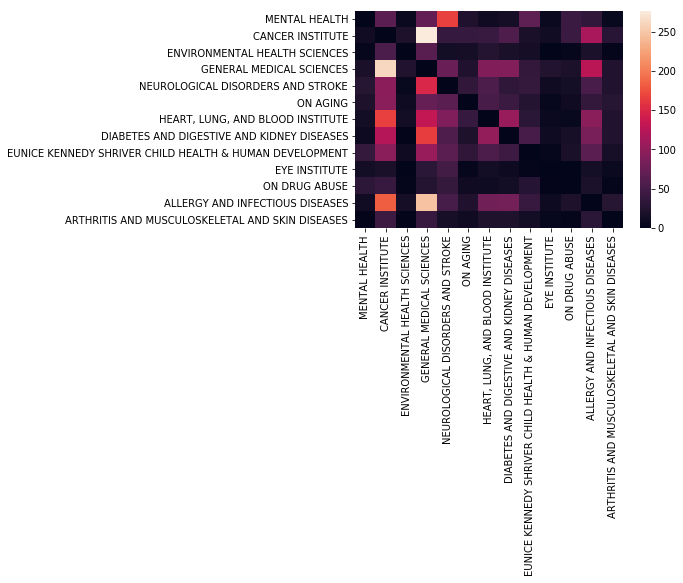

In [91]:
# create a confusion matrix
heatmap_df = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred), columns=labels, index=labels)

# set the diagonal (i.e. correct predictions) to zero so that they do not over-influence the heatmap legend
np.fill_diagonal(heatmap_df.values, 0)

# plot the confusion matrix
sns.heatmap(heatmap_df)

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorize text
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,1))
X_train_vect = tfidf.fit_transform(X_train)
X_test_vect = tfidf.transform(X_test)

# train model
logreg = LogisticRegression(solver='lbfgs', max_iter=300, multi_class='auto')
logreg.fit(X_train_vect, y_train)

# store predictions
y_pred = logreg.predict(X_test_vect)
y_pred_proba = logreg.predict_proba(X_test_vect)

# evaluate model
print(f'accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'log loss (cross-entropy): {metrics.log_loss(y_test, y_pred_proba)}')

accuracy: 0.6880255524411707
log loss (cross-entropy): 1.133580209765361


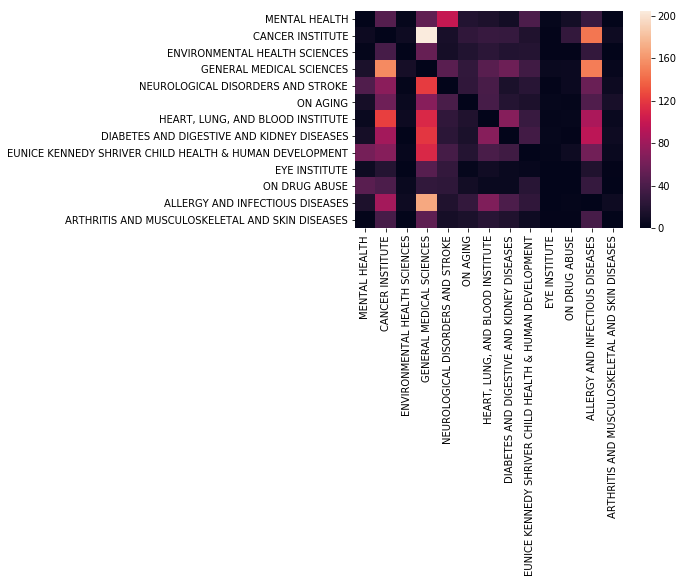

In [93]:
# create a confusion matrix
heatmap_df = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred), columns=labels, index=labels)

# set the diagonal (i.e. correct predictions) to zero so that they do not over-influence the heatmap legend
np.fill_diagonal(heatmap_df.values, 0)

# plot the confusion matrix
sns.heatmap(heatmap_df)

# Full Embedding and Model Pipeline Class

In [0]:
class EmbeddingModel:
    
    def __init__(self, X_train, X_test, y_train, y_test, 
                 max_num_words=20000, max_seq_length=50, embedding_size=50, embedding_dir=None):
                
        # set tokenizer params
        self.max_num_words = max_num_words
        self.max_seq_length = max_seq_length
        self.vocab_size = None
        self.tokenizer = None

        # format data
        self.num_classes = len(set(y_train))        
        self.y_train_array = to_categorical(y_train, self.num_classes)
        self.y_test_array = to_categorical(y_test, self.num_classes)
        self.X_train = X_train
        self.X_test = X_test
        self.X_train_sequence = self.encode_text(X_train, train=True)
        self.X_test_sequence = self.encode_text(X_test, train=False)
                
        # set embedding params
        self.embedding_dir = embedding_dir
        self.embedding_size = embedding_size
        self.embeddings_index = None
        self.embedding_matrix = None
        
        # set model params
        self.model = None
    
    def setup_model_pipeline(self):
        self.create_embeddings_index()
        self.create_embedding_matrix()
        print('model pipeline set-up complete')

    def encode_text(self, text, train=False):
        if train:
            self.tokenizer = Tokenizer(num_words=self.max_num_words)
            self.tokenizer.fit_on_texts(text)

        encoded_docs = self.tokenizer.texts_to_sequences(text)
        padded_docs = pad_sequences(
            encoded_docs,
            maxlen=self.max_seq_length,
            padding='post'
        )

        print(f'completed tokenizing and padding text - train: {train}')
        self.vocab_size = len(self.tokenizer.word_index) + 1
        return padded_docs

    def create_embeddings_index(self):
        embeddings_index = {}

        with open(self.embedding_dir, 'rb') as f:
            for line in f:
                values = line.split()
                word = values[0].decode('utf-8')
                embedding = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = embedding

        print('completed creating embedding index')
        self.embeddings_index = embeddings_index

    def create_embedding_matrix(self):
        embedding_matrix = zeros((self.vocab_size, self.embedding_size))

        for word, i in self.tokenizer.word_index.items():    
            embedding_vector = self.embeddings_index.get(word)

            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

        print('completed creating embedding matrix')
        self.embedding_matrix = embedding_matrix

    def get_embedding_layer(self):
        embedding = Embedding(
            input_dim=self.vocab_size, 
            output_dim=self.embedding_size,                                    
            input_length=self.max_seq_length,
            embeddings_initializer=Constant(self.embedding_matrix),
            trainable=False                                   
        )

        return embedding

    def fit(self, model=None, epochs=10):
        if model:
            print('using custom model')
        else:
            # default model if a custom model is not provided
            model = Sequential()
            model.add(self.get_embedding_layer())
            model.add(Flatten())
            model.add(Dense(self.num_classes, activation='softmax'))
            model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # train model
        model.fit(
            self.X_train_sequence, 
            self.y_train_array,
            epochs=epochs,
            validation_data=(self.X_test_sequence, self.y_test_array)
        )

        print('completed training model')
        self.model = model
        
    def predict(self, X):
        encoded_text = self.encode_text(X, train=False)
        y_pred = self.model.predict_classes(encoded_text)
        
        return y_pred

In [114]:
# instantiate nlp model pipeline
embedding_model = EmbeddingModel(
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test,
    max_num_words=25000,
    max_seq_length=75,
    embedding_dir=r'glove.6B.300d.txt',
    embedding_size=EMBEDDING_SIZE
)

# set-up and train model
embedding_model.setup_model_pipeline()
embedding_model.fit(epochs=4)

completed tokenizing and padding text - train: True
completed tokenizing and padding text - train: False
completed creating embedding index
completed creating embedding matrix
model pipeline set-up complete
Train on 46022 samples, validate on 15341 samples
Epoch 1/4
46022/46022 [==============================] - 5s 110us/step - loss: 1.6259 - acc: 0.5000 - val_loss: 1.4609 - val_acc: 0.5532
Epoch 2/4
46022/46022 [==============================] - 5s 99us/step - loss: 1.2936 - acc: 0.6040 - val_loss: 1.4326 - val_acc: 0.5667
Epoch 3/4
46022/46022 [==============================] - 4s 98us/step - loss: 1.1901 - acc: 0.6328 - val_loss: 1.4418 - val_acc: 0.5688
Epoch 4/4
46022/46022 [==============================] - 4s 97us/step - loss: 1.1302 - acc: 0.6508 - val_loss: 1.4606 - val_acc: 0.5691
completed training model


# Use content specific Embeddings

##### bioasq

"We applied word2vec to a corpus of 10,876,004 English abstracts of biomedical articles from PubMed. The resulting vectors of 1,701,632 distinct words (types) are now publicly available from http://bioasq.lip6.fr/tools/BioASQword2vec/. File size: 1.3GB (compressed), 3.5GB (uncompressed)."

SOURCE: http://bioasq.org/news/bioasq-releases-continuous-space-word-vectors-obtained-applying-word2vec-pubmed-abstracts

In [104]:
!wget http://bioasq.lip6.fr/tools/BioASQword2vec/

--2019-06-14 04:14:19--  http://bioasq.lip6.fr/tools/BioASQword2vec/
Resolving bioasq.lip6.fr (bioasq.lip6.fr)... 132.227.201.38
Connecting to bioasq.lip6.fr (bioasq.lip6.fr)|132.227.201.38|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://participants-area.bioasq.org/tools/BioASQword2vec/ [following]
--2019-06-14 04:14:20--  http://participants-area.bioasq.org/tools/BioASQword2vec/
Resolving participants-area.bioasq.org (participants-area.bioasq.org)... 143.233.226.90
Connecting to participants-area.bioasq.org (participants-area.bioasq.org)|143.233.226.90|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1341997858 (1.2G) [application/force-download]
Saving to: ‘index.html’

index.html          100%[===================>]   1.25G  4.02MB/s    in 4m 38s  

2019-06-14 04:18:59 (4.60 MB/s) - ‘index.html’ saved [1341997858/1341997858]



In [113]:
!mv index.html bio.tar.gz
!ls

#tar -xvzf community_images.tar.gz

bio.tar.gz	   glove.6B.300d.txt  RePORTER_PRJ_C_FY2017.zip
glove.6B.100d.txt  glove.6B.50d.txt   sample_data
glove.6B.200d.txt  glove.6B.zip


In [114]:
%%time

!tar -xvzf bio.tar.gz

word2vecTools/toolkit.py
word2vecTools/vectors.txt
word2vecTools/
word2vecTools/README_BioASQ_word_vectors.pdf
word2vecTools/types.txt
word2vecTools/train_vectors.sh


In [130]:
!ls

bio.tar.gz	   glove.6B.300d.txt  RePORTER_PRJ_C_FY2017.zip
glove.6B.100d.txt  glove.6B.50d.txt   sample_data
glove.6B.200d.txt  glove.6B.zip       word2vecTools


In [0]:
class BioasqEmbeddingModel(EmbeddingModel):

    # override the EmbeddingModel's create_embeddings_index to read in bioasq embeddings
    def create_embeddings_index(self):

        # read in a file with all the learned tokens
        with open(r'word2vecTools/types.txt', 'r') as f:
            tokens = [line.strip() for line in f]

        # read in a file with the associated embeddings for the tokens
        with open('word2vecTools/vectors.txt', 'rb') as f:
            embeddings = [np.asarray(embedding.split(), dtype='float32') for embedding in f]

        # create a dict of the word --> embedding mappings
        embeddings_index = {word:embedding for word, embedding in zip(tokens, embeddings)}

        print('completed creating pubmed embedding index')
        self.embeddings_index = embeddings_index

In [146]:
%%time

# set-up model pipeline
bioasq_model = BioasqEmbeddingModel(
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train,
    y_test=y_test,
    max_num_words=25000,
    max_seq_length=75,
    embedding_size=200
)
bioasq_model.setup_model_pipeline()

completed tokenizing and padding text - train: True
completed tokenizing and padding text - train: False
completed creating pubmed embedding index
completed creating embedding matrix
model pipeline set-up complete
CPU times: user 55.8 s, sys: 2.16 s, total: 57.9 s
Wall time: 57.8 s


In [148]:
%%time

# default model if a custom model is not provided
model = Sequential()
model.add(bioasq_model.get_embedding_layer())
model.add(Flatten())
model.add(Dense(bioasq_model.num_classes, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train model
bioasq_model.fit(epochs=10, model=model)

using custom model
Train on 46022 samples, validate on 15341 samples
Epoch 1/10
46022/46022 [==============================] - 5s 102us/step - loss: 1.5680 - acc: 0.5354 - val_loss: 1.3507 - val_acc: 0.5955
Epoch 2/10
46022/46022 [==============================] - 4s 92us/step - loss: 1.2143 - acc: 0.6363 - val_loss: 1.2756 - val_acc: 0.6100
Epoch 3/10
46022/46022 [==============================] - 4s 92us/step - loss: 1.1155 - acc: 0.6622 - val_loss: 1.2522 - val_acc: 0.6188
Epoch 4/10
46022/46022 [==============================] - 4s 91us/step - loss: 1.0581 - acc: 0.6783 - val_loss: 1.2470 - val_acc: 0.6193
Epoch 5/10
46022/46022 [==============================] - 4s 90us/step - loss: 1.0190 - acc: 0.6886 - val_loss: 1.2493 - val_acc: 0.6210
Epoch 6/10
46022/46022 [==============================] - 4s 92us/step - loss: 0.9896 - acc: 0.6976 - val_loss: 1.2546 - val_acc: 0.6221
Epoch 7/10
46022/46022 [==============================] - 4s 91us/step - loss: 0.9665 - acc: 0.7056 - val_lo

##### Biomedical natural language processing (Pubmed, PMC, and Wikipedia combined embeddings)

NOTE: This embedding file is 4GB

"The openly available biomedical literature contains over 5 billion words in publication abstracts and full texts. Recent advances in unsupervised language processing methods have made it possible to make use of such large unannotated corpora for building statistical language models and inducing high quality vector space representations, which are, in turn, of utility in many tasks such as text classification, named entity recognition and query expansion. In this study, we introduce the first set of such language resources created from analysis of the entire available biomedical literature, including a dataset of all 1- to 5-grams and their probabilities in these texts and new models of word semantics. We discuss the opportunities created by these resources and demonstrate their application. All resources introduced in this study are available under open licenses at http://bio.nlplab.org."

SOURCE: http://bio.nlplab.org/#word-vector-tools
PUBLICATION: http://bio.nlplab.org/pdf/pyysalo13literature.pdf

In [1]:
!wget http://evexdb.org/pmresources/vec-space-models/wikipedia-pubmed-and-PMC-w2v.bin

--2019-06-14 15:05:14--  http://evexdb.org/pmresources/vec-space-models/wikipedia-pubmed-and-PMC-w2v.bin
Resolving evexdb.org (evexdb.org)... 130.232.253.44
Connecting to evexdb.org (evexdb.org)|130.232.253.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4416560851 (4.1G) [application/octet-stream]
Saving to: ‘wikipedia-pubmed-and-PMC-w2v.bin’

wikipedia-pubmed-an 100%[===================>]   4.11G  1015KB/s    in 70m 35s 

2019-06-14 16:15:50 (1018 KB/s) - ‘wikipedia-pubmed-and-PMC-w2v.bin’ saved [4416560851/4416560851]



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp wikipedia-pubmed-and-PMC-w2v.bin gdrive/My\ Drive

In [97]:
!ls

gdrive		   glove.6B.300d.txt  RePORTER_PRJ_C_FY2017.zip
glove.6B.100d.txt  glove.6B.50d.txt   sample_data
glove.6B.200d.txt  glove.6B.zip       wikipedia-pubmed-and-PMC-w2v.bin


In [0]:
class PubmedEmbeddingModel(EmbeddingModel):

    # override the EmbeddingModel's create_embeddings_index to read in pubmed embeddings
    def create_embeddings_index(self):

        embedding_path = r'wikipedia-pubmed-and-PMC-w2v.bin'
        word_vectors = KeyedVectors.load_word2vec_format(embedding_path, binary=True)

        # create a dict of the word --> embedding mappings
        embeddings_index = {word: word_vectors.get_vector(word) for word in word_vectors.index2word}

        print('completed creating pubmed embedding index')
        self.embeddings_index = embeddings_index

In [99]:
%%time

# set-up model pipeline
pubmed_model = PubmedEmbeddingModel(
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train,
    y_test=y_test,
    max_num_words=25000,
    max_seq_length=75,
    embedding_size=200
)
pubmed_model.setup_model_pipeline()

completed tokenizing and padding text - train: True
completed tokenizing and padding text - train: False


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


completed creating pubmed embedding index
completed creating embedding matrix
model pipeline set-up complete
CPU times: user 1min 12s, sys: 6.74 s, total: 1min 19s
Wall time: 1min 19s


In [100]:
%%time

pubmed_model.fit(epochs=15)

Train on 46022 samples, validate on 15341 samples
Epoch 1/15
46022/46022 [==============================] - 5s 98us/step - loss: 1.6027 - acc: 0.5194 - val_loss: 1.4014 - val_acc: 0.5772
Epoch 2/15
46022/46022 [==============================] - 4s 94us/step - loss: 1.2672 - acc: 0.6172 - val_loss: 1.3255 - val_acc: 0.5947
Epoch 3/15
46022/46022 [==============================] - 4s 93us/step - loss: 1.1715 - acc: 0.6459 - val_loss: 1.3004 - val_acc: 0.6032
Epoch 4/15
46022/46022 [==============================] - 4s 93us/step - loss: 1.1155 - acc: 0.6591 - val_loss: 1.2983 - val_acc: 0.6058
Epoch 5/15
46022/46022 [==============================] - 4s 92us/step - loss: 1.0767 - acc: 0.6710 - val_loss: 1.3002 - val_acc: 0.6038
Epoch 6/15
46022/46022 [==============================] - 4s 93us/step - loss: 1.0475 - acc: 0.6805 - val_loss: 1.3008 - val_acc: 0.6039
Epoch 7/15
46022/46022 [==============================] - 4s 92us/step - loss: 1.0236 - acc: 0.6869 - val_loss: 1.3087 - val_acc

# 4. build a deep learning model (e.g. convolutional neural network), ending in a softmax output.

### Convolutional Neural Networ (CNN)

In [149]:
embedding_model.num_classes

13

In [0]:
# define model

def build_cnn_model(model):
    cnn_model = Sequential()
    cnn_model.add(model.get_embedding_layer())

    cnn_model.add(Conv1D(512, 1, activation='relu'))
    cnn_model.add(MaxPooling1D(4))
    cnn_model.add(Dropout(.5))

    cnn_model.add(Conv1D(256, 1, activation='relu'))
    cnn_model.add(MaxPooling1D(1))
    cnn_model.add(Dropout(.4))

    cnn_model.add(Conv1D(128, 1, activation='relu'))
    cnn_model.add(MaxPooling1D(1))
    cnn_model.add(Dropout(.3))

    cnn_model.add(Conv1D(64, 1, activation='relu'))
    cnn_model.add(MaxPooling1D(1))
    cnn_model.add(Dropout(.2))

    
    cnn_model.add(GlobalAveragePooling1D())

    cnn_model.add(Dense(units=64, activation='relu'))
    cnn_model.add(Dense(units=64, activation='relu'))

    cnn_model.add(Dense(model.num_classes, activation='softmax'))
    cnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return cnn_model

In [0]:
# set-up and train model
cnn_model = build_cnn_model(embedding_model)
embedding_model.fit(epochs=15, model=cnn_model)

In [0]:
cnn_model = build_cnn_model(bioasq_model)
bioasq_model.fit(epochs=15, model=cnn_model)

In [1]:
cnn_model = build_cnn_model(pubmed_model)
pubmed_model.fit(epochs=15, model=cnn_model)

NameError: ignored

### LSTM

In [0]:
# define model
def build_lstm(model):
    lstm_model = Sequential()
    lstm_model.add(model.get_embedding_layer())
    lstm_model.add(LSTM(64))
    lstm_model.add(Dense(model.num_classes, activation='softmax'))
    lstm_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return lstm_model

In [159]:
# set-up and train model
lstm_model = build_lstm(embedding_model)
embedding_model.fit(epochs=4, model=lstm_model)

using custom model
Train on 46022 samples, validate on 15341 samples
Epoch 1/4
46022/46022 [==============================] - 174s 4ms/step - loss: 2.0593 - acc: 0.2899 - val_loss: 1.9241 - val_acc: 0.3843
Epoch 2/4
46022/46022 [==============================] - 171s 4ms/step - loss: 1.8765 - acc: 0.3879 - val_loss: 1.8170 - val_acc: 0.4107
Epoch 3/4
46022/46022 [==============================] - 171s 4ms/step - loss: 1.7767 - acc: 0.4220 - val_loss: 1.9363 - val_acc: 0.3765
Epoch 4/4
46022/46022 [==============================] - 170s 4ms/step - loss: 1.6649 - acc: 0.4620 - val_loss: 1.6117 - val_acc: 0.4775
completed training model


In [108]:
# set-up and train model
lstm_model = build_lstm(bioasq_model)
bioasq_model.fit(epochs=25, model=lstm_model)

NameError: ignored

In [107]:
lstm_model = build_lstm(pubmed_model)
pubmed_model.fit(epochs=25, model=lstm_model)

using custom model
Train on 46022 samples, validate on 15341 samples
Epoch 1/25
46022/46022 [==============================] - 173s 4ms/step - loss: 2.0310 - acc: 0.2950 - val_loss: 1.9802 - val_acc: 0.3540
Epoch 2/25
46022/46022 [==============================] - 172s 4ms/step - loss: 1.8118 - acc: 0.4102 - val_loss: 1.7403 - val_acc: 0.4432
Epoch 3/25
46022/46022 [==============================] - 171s 4ms/step - loss: 1.6604 - acc: 0.4674 - val_loss: 1.5735 - val_acc: 0.4947
Epoch 4/25
46022/46022 [==============================] - 172s 4ms/step - loss: 1.5358 - acc: 0.5038 - val_loss: 1.4728 - val_acc: 0.5247
Epoch 5/25
46022/46022 [==============================] - 171s 4ms/step - loss: 1.3421 - acc: 0.5877 - val_loss: 1.3001 - val_acc: 0.6089
Epoch 6/25
46022/46022 [==============================] - 171s 4ms/step - loss: 1.2130 - acc: 0.6387 - val_loss: 1.2370 - val_acc: 0.6284
Epoch 7/25
46022/46022 [==============================] - 171s 4ms/step - loss: 1.1385 - acc: 0.6598 - 

# FLAIR 

In [0]:
https://github.com/zalandoresearch/flair/blob/master/flair/embeddings.py
    
embedding example: 
#    def _add_embeddings_internal(self, sentences: List[Sentence]) -> List[Sentence]: